## Evaluation of Text-to-Image Conditional Diffusion Model with Classifier-Free Guidance

This notebook evaluates the pre-trained text-to-image diffusion model on generating flower images. The assessment focuses on both the quality of the generated images and an analysis of the model's internal representations. The main steps of the evaluation are:

- **Image Generation:** Produce high-quality flower images from text prompts using the conditional UNet-DDPM model with Classifier-Free Guidance (CFG).  
- **Embedding Extraction:** Capture intermediate feature representations from the U-Net’s downsampling path during generation to analyze what the model has learned.  
- **Quantitative Evaluation:** Measure generation quality using **CLIP Score** and **Fréchet Inception Distance (FID)**.  
- **Visualization & Analysis:** Create a FiftyOne dataset to inspect generated images, metadata, and embeddings; use FiftyOne Brain to compute uniqueness and representativeness scores.  
- **Experiment Tracking:** Log hyperparameters, metrics, and evaluation results to the [diffusion-model-assessment-v2 W&B project](https://wandb.ai/handsoncv-research/diffusion-model-assessment-v2/workspace) for reproducibility and comparison across experiments; for reefrence, see the runs `*-evaluation`.  

In the following cell, we import modules and functions from our `src` package, set random seeds for reproducibility, and define the parameters and file paths used throughout the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import clip
import os 

# On a multi-GPU system, this hides all GPUs except the first 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import fiftyone as fo
import fiftyone.brain as fob
import torchvision.transforms as transforms
import wandb 

from torch.utils.data import DataLoader
from huggingface_hub import snapshot_download

# Custom modules
from handsoncv.datasets import TFflowersCLIPDataset
from handsoncv.models import UNet
from handsoncv.metrics import extract_inception_features
from handsoncv.utils import DDPM, set_seed, seed_worker
from handsoncv.evaluation import Evaluator

# Hardware & Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-3")
ROOT_DATA = os.path.join(ROOT_PATH, "data")
DATA_DIR = f"{ROOT_DATA}/cropped_flowers"
SAMPLE_DIR = f"{ROOT_DATA}/05_images"
CSV_PATH = f"{ROOT_DATA}/clip_embeddings_metadata.csv"

CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Numpy and Torch Reproducibility
SEED=42
set_seed(42)

# Base Configuration Parameters
BATCH_SIZE = 32
REPO_ID = "vanessaguarino/TFflowers-diffusion-assessment"

cuda
Seeds set to 42 for reproducibility.


In [2]:
# Load UNet/DDPM trained in notebook '05_a_*'
model = UNet(400, 3, 32, down_chs=(256, 256, 512)).to(DEVICE)
model.load_state_dict(torch.load(f"{CHECKPOINTS_DIR}/ddpm_unet_best_model.pt"))
ddpm = DDPM(torch.linspace(0.0001, 0.02, 400).to(DEVICE), DEVICE)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE)

In [3]:
# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

# Base transforms used by both training and validation data
base_t = [
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
]

# Create a DataLoader for original (real) images
ds = TFflowersCLIPDataset(CSV_PATH, transform=transforms.Compose(base_t))
data_loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, generator=g)

In [4]:
# Assessment Part 1 & 2: Generation, Embedding Extraction, CLIP Score and FID
# For inspection of the exact functions, please refer to sample_flowers in src/handsoncv/utils.py and Evaluator class in src/handsoncv/evaluation.py
evaluator = Evaluator(model, ddpm, clip_model, clip_preprocess, DEVICE, results_dir="results/eval_01")

# Define list of text prompts to generate images for
text_prompts = [
    "A red rose flower",
    "A deep red rose",
    "A rose with layered petals",
    "A red rose with layered petals",
    "A pink rose flower",
    "A detailed rose flower",
    "A close-up of a rose",
    
    "Two sunflowers with big brown centers",
    "A sunflower flower",
    "A sunflower with bright yellow petals",
    "An orange sunflower with a big brown center",
    "A bright yellow sunflower",
    "A close-up of a sunflower",
    "A large sunflower",
    "A sunflower with limp, drooping petals",
    
    "A white daisy with a yellow center",
    "A round white daisy",
    "A daisy flower",
    "A detailed daisy flower",
    "A close-up of a daisy",
    "A daisy covered in dew",
    "Two daisies",
    "Two white daisies with yellow centers",
]

eval_results, fid = evaluator.run_full_evaluation(
    text_prompts * 40,
    real_dataloader=data_loader,
    w_tests=[3.0],
)

print(f"FID Score: {fid}")

FID Score: 87.50288488046954


In [5]:
eval_results[:23]

[{'prompt': 'A red rose flower',
  'img_path': '/home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/notebooks/results/eval_01/gen_000.png',
  'clip_score': 0.270263671875,
  'embedding': array([ 0.39805484,  0.65238875,  0.7056522 , ..., -0.15339597,
         -0.13675547, -0.06015807], shape=(32768,), dtype=float32)},
 {'prompt': 'A deep red rose',
  'img_path': '/home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/notebooks/results/eval_01/gen_001.png',
  'clip_score': 0.2476806640625,
  'embedding': array([ 0.4200087 ,  0.70633537,  0.761963  , ..., -0.14985378,
         -0.13762657, -0.06149215], shape=(32768,), dtype=float32)},
 {'prompt': 'A rose with layered petals',
  'img_path': '/home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/notebooks/results/eval_01/gen_002.png',
  'clip_score': 0.261962890625,
  'embedding': array([ 0.37419423,  0.6387706 ,  0.75920177, ..., -0.14546733,
         -0.13869204, -0.0760

 100% |███████████████████| 23/23 [184.8ms elapsed, 0s remaining, 126.6 samples/s]    
Computing brain metrics...
Computing embeddings...
 100% |███████████████████| 23/23 [1.6s elapsed, 0s remaining, 14.4 samples/s]      
Computing uniqueness...
Uniqueness computation complete
Computing representativeness...
Computing clusters for 23 embeddings; this may take awhile...
Representativeness computation complete



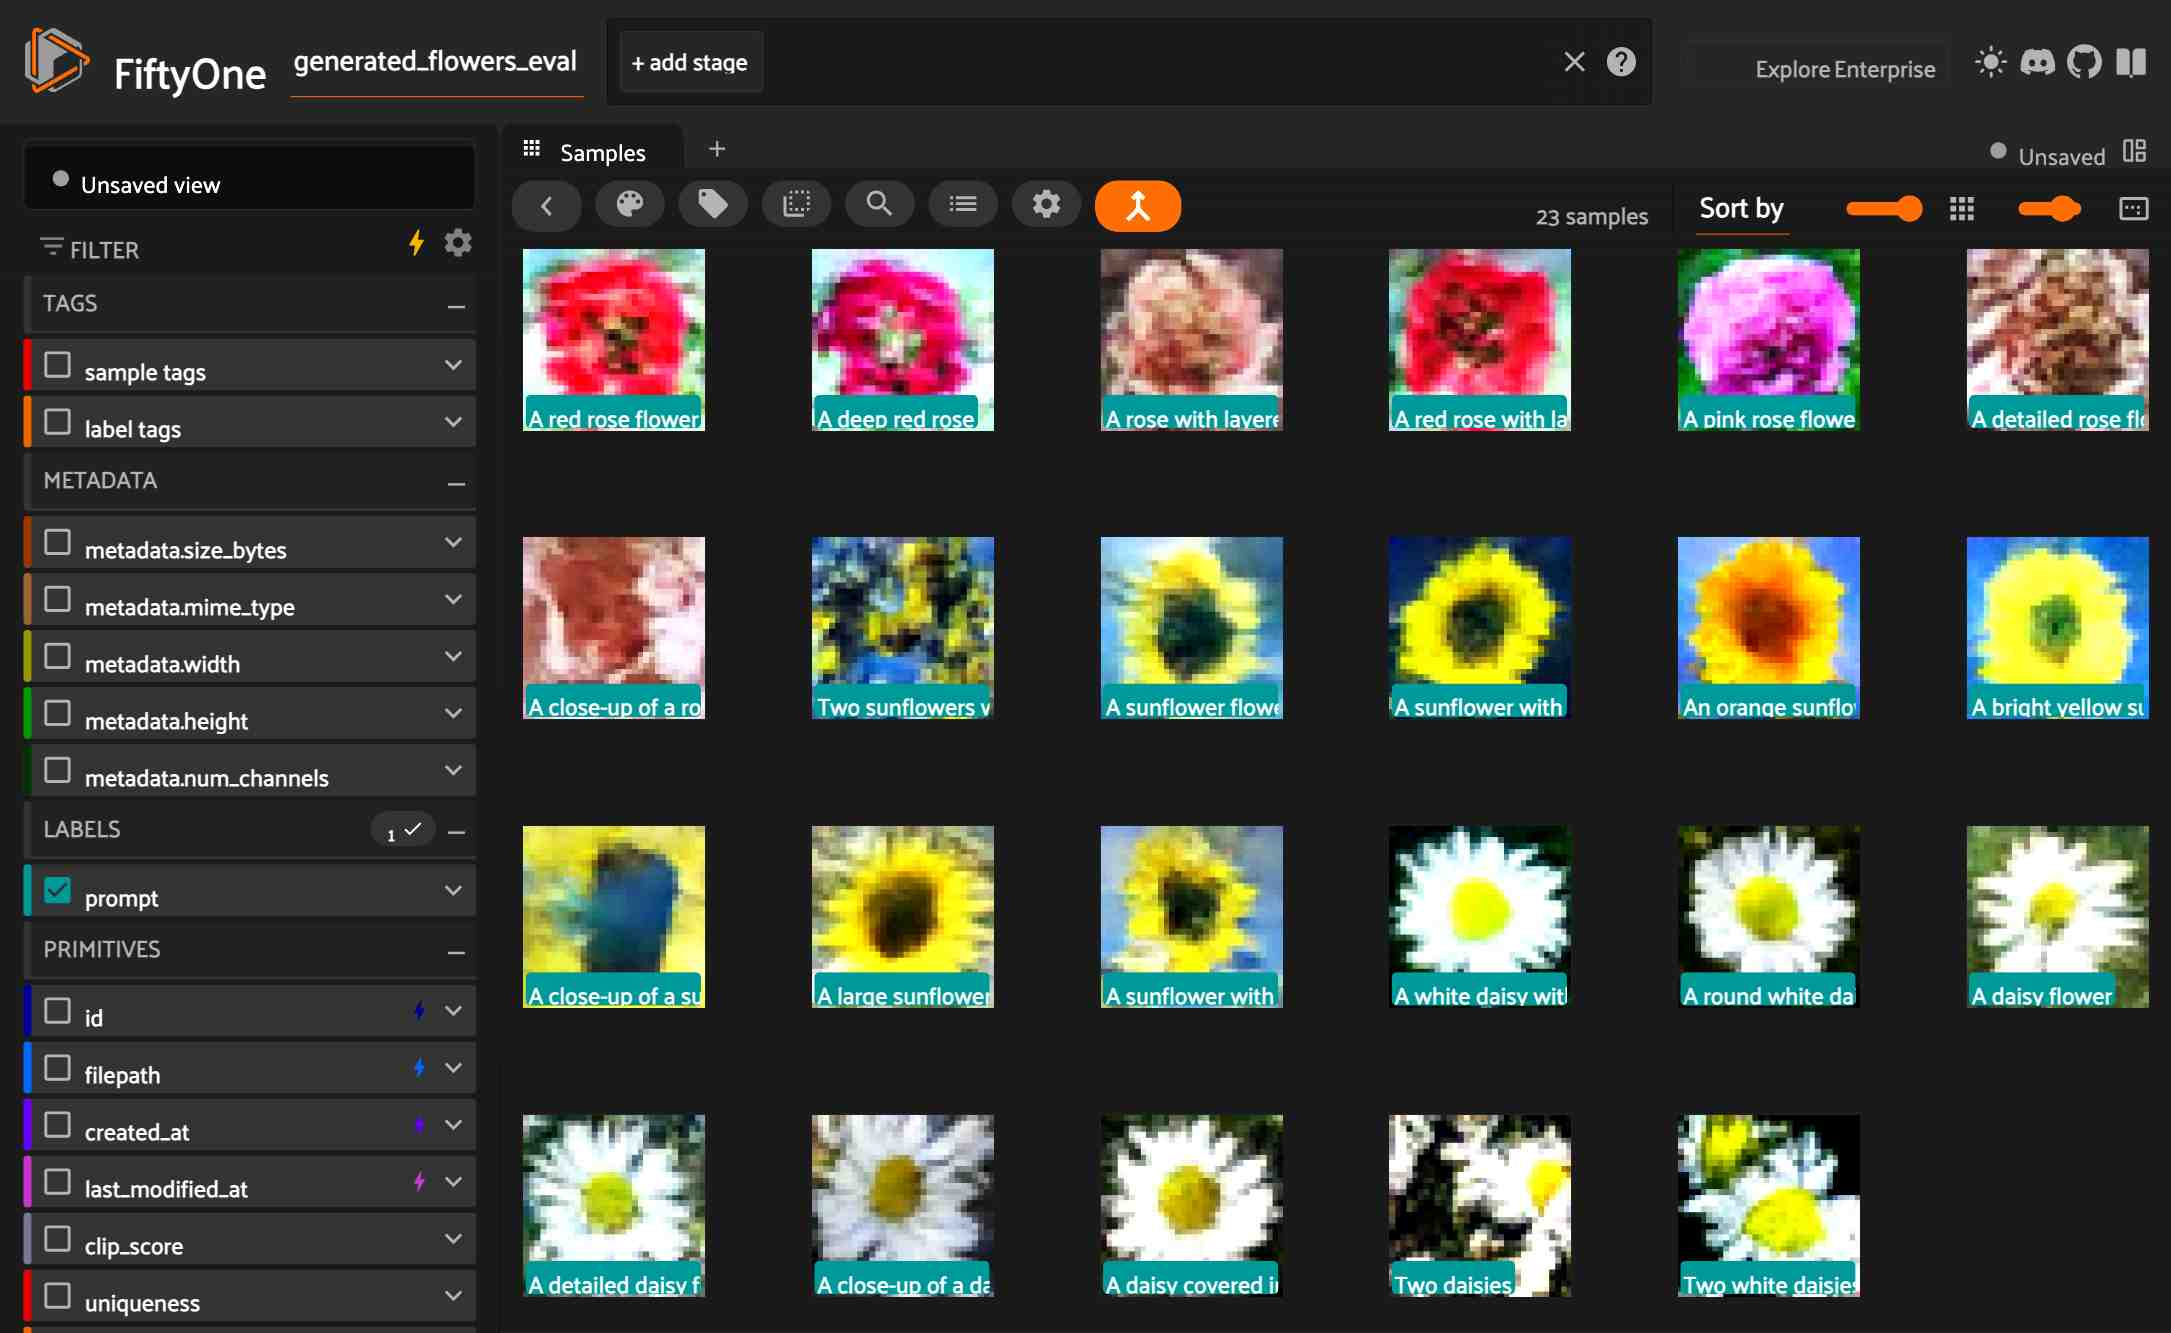

In [ ]:
# Assessment Part 3: FiftyOne Analysis
dataset = fo.Dataset(name="generated_flowers_eval", overwrite=True)
samples = []

# eval_results now contains 23 items (23 prompts * 1 "visually-optimal" guidance scale)
for res in eval_results[:len(text_prompts)]:
    sample = fo.Sample(filepath=res["img_path"])
    sample["prompt"] = fo.Classification(label=res["prompt"])
    sample["clip_score"] = res["clip_score"]
    sample["unet_embedding"] = res["embedding"]
    samples.append(sample)

dataset.add_samples(samples)

# Run if we have enough samples to satisfy FiftyOne's default clustering
if len(dataset) >= 20:
    print("Computing brain metrics...")
    fob.compute_uniqueness(dataset)
    fob.compute_representativeness(dataset, embeddings="unet_embedding")
else:
    print(f"Dataset size ({len(dataset)}) is too small for representativeness (needs 20+).")

session = fo.launch_app(dataset)

In [8]:
# Initialize W&B Run
run = wandb.init(
    project="diffusion-model-assessment-v2", 
    name="ddpm_unet_evaluation",
    job_type="evaluation"
)

# Log Hyperparameters
BOTTLE_EMB_CHANNELS = model.down2.model[-2].model[0].out_channels #extracted from the output channels of the model's `down2` layer
IMG_SIZE = next(iter(data_loader))[0].shape[-1] #extracted from first dataloader sample

wandb.config.update({
    "T": model.T,
    "img_size": IMG_SIZE, #extracted from first dataloader sample
    "guidance_weight_w": 3.0, # Or the specific value set in evaluator.run_full_evaluation() as w_tests
    "architecture": "ddpm_unet",
    "num_samples": len(dataset),
    "embedding_size": BOTTLE_EMB_CHANNELS,
    "prompts": text_prompts,
})

# Log Aggregate Evaluation Metrics
avg_clip_score = dataset.mean("clip_score") # Compute average CLIP score from the FiftyOne dataset

wandb.log({
    "final_fid_score": fid,
    "average_clip_score": avg_clip_score
})

# Create and Log the Results Table
# We iterate through the FiftyOne dataset to get the brain metrics 
results_table = wandb.Table(columns=[
    "generated_image", 
    "text_prompt", 
    "clip_score", 
    "uniqueness", 
    "representativeness"
])

print("Syncing FiftyOne results to WandB Table...")

for sample in dataset:
    # Convert image tensor/path to wandb.Image
    img = wandb.Image(sample.filepath, caption=sample.prompt.label)  # We use the absolute path stored in FiftyOne
    
    # Add row to table
    results_table.add_data(
        img,
        sample.prompt.label,
        sample.clip_score,
        sample.uniqueness,
        sample.representativeness
    )

# Log the table to W&B
wandb.log({"evaluation_results_table": results_table})

# Finish the run
print("Evaluation logging complete!")
run.finish()

Syncing FiftyOne results to WandB Table...
Evaluation logging complete!


average_clip_score,▁
final_fid_score,▁
average_clip_score,0.27187
final_fid_score,87.50031


In [12]:
# Define the export path and a metadata.jsonl file so the scores show up in the table
export_dir = os.path.join(ROOT_DATA, "hf_flower_evaluation_export")

# Perform the export
# This creates a folder containing:
# - data/ (the images)
# - samples.json (all metrics: clip_score, uniqueness, representativeness, embeddings)
# - metadata.json (dataset info)
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True
)

print(f"FiftyOne dataset exported to {export_dir}")

Exporting samples...
 100% |██████████████████████| 23/23 [24.1ms elapsed, 0s remaining, 953.4 docs/s] 


FiftyOne dataset exported to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/hf_flower_evaluation_export


In [18]:
# Download the snapshot from Hugging Face
local_dir = snapshot_download(repo_id=REPO_ID, repo_type="dataset")
fiftyone_dataset_name = "restored_flower_assessment"

if fiftyone_dataset_name in fo.list_datasets():
    fo.delete_dataset(fiftyone_dataset_name)

# Load it back into FiftyOne
restored_dataset = fo.Dataset.from_dir(
    dataset_dir=local_dir,
    dataset_type=fo.types.FiftyOneDataset,
    name=fiftyone_dataset_name
)

# Verify
print(restored_dataset)
fo.launch_app(restored_dataset)

Fetching 52 files:   0%|          | 0/52 [00:00<?, ?it/s]

Importing samples...
 100% |███████████████████| 23/23 [9.7ms elapsed, 0s remaining, 2.4K samples/s]      
Name:        restored_flower_assessment
Media type:  image
Num samples: 23
Persistent:  False
Tags:        []
Sample fields:
    id:                 fiftyone.core.fields.ObjectIdField
    filepath:           fiftyone.core.fields.StringField
    tags:               fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:         fiftyone.core.fields.DateTimeField
    last_modified_at:   fiftyone.core.fields.DateTimeField
    prompt:             fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    clip_score:         fiftyone.core.fields.FloatField
    unet_embedding:     fiftyone.core.fields.VectorField
    uniqueness:         fiftyone.core.fields.FloatField
    representativeness: fiftyone.core.fields.FloatField


Dataset:          restored_flower_assessment
Media type:       image
Num samples:      23
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/